In [2]:
import igraph as ig
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

random.seed(0)

# Part 1

## 1a

A binomial distribution is observed. This is because there are $n-1 \choose d$ ways to choose $d$ vertices among $n-1$ nodes (we exclude self-connections). Each node has $p^d$ probability of connecting to $d$ vertices. Since these must be no edges to the remaining $n-1-d$ nodes which occur with probability $(1-p)^{n-1-d}$ we get the probability that 2 nodes are connected as $Prob[d] = {n-1\choose d} p^d (1-p)^{n-1-d}$. Since $n$ is sufficiently large $n-1\approx n$

   Theoretical Mean  Calc Mean  Theoretical Variance  Calc Variance
0             1.798   1.773333              1.794404       1.730844
1             5.394   5.382222              5.361636       5.425017
2            10.788  10.706667             10.658544      10.965067
3            40.455  40.591111             38.634525      38.128365
4            89.900  90.017778             80.910000      84.841906


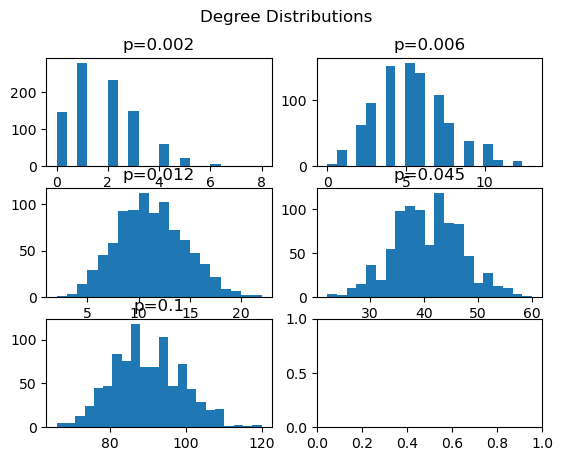

In [3]:
# 1a
# create an undirected random network
n_nodes = 900
probabilities = [0.002, 0.006, 0.012, 0.045, 0.1] # prob that edge exists b/w 2 vertices

fig, axs = plt.subplots(3, 2)
fig.suptitle('Degree Distributions')
theor_means = []
theor_vars = []
calc_means = []
calc_vars = []
graphs = []

for p, ax in zip(probabilities, axs.reshape(-1)):
    graph = ig.Graph.Erdos_Renyi(n=n_nodes, p=p, directed=False, loops=False)
    graphs.append(graph)
    degrees = [v.degree() for v in graph.vs]

    # Theoretical mean and variance of degree distribution
    # we use (n-1) since a node can't connect to itself
    # Erdos-Renyi Graph follows a binomial distribution. These are binomial mean/var from wikipedia
    # https://chih-ling-hsu.github.io/2020/05/15/Gnp
    # https://www.cs.cmu.edu/~avrim/598/chap4only.pdf
    theor_means.append((n_nodes-1)*p)
    theor_vars.append((n_nodes-1)*p*(1-p))
    calc_means.append(np.mean(degrees))
    calc_vars.append(np.var(degrees))

    ax.hist(degrees, bins='auto')
    ax.title.set_text(f'p={p}')

print(pd.DataFrame({
    "Theoretical Mean": theor_means, 
    "Calc Mean": calc_means, 
    "Theoretical Variance": theor_vars, 
    "Calc Variance": calc_vars
}))

## 1b

In [5]:
n_iter = 1000

for p, g in zip(probabilities, graphs):
    out_str = f'p={p}, connected={g.is_connected()}'

    # Numerically estimate the probability that a generated network is connected
    connected = 0
    for i in range(n_iter):
        graph = ig.Graph.Erdos_Renyi(n=n_nodes, p=p, directed=False, loops=False)
        connected += graph.is_connected()
    prob_connected = connected/n_iter
    out_str += f', prob_connected={prob_connected}'

    # if a graph is not connected estimate the diameter of the giant component
    if not g.is_connected():
        g = g.connected_components().giant()
        out_str += f', diameter={g.diameter()}'
    print(out_str)

p=0.002, connected=False, prob_connected=0.0, diameter=24
p=0.006, connected=False, prob_connected=0.015, diameter=9
p=0.012, connected=True, prob_connected=0.981
p=0.045, connected=True, prob_connected=1.0
p=0.1, connected=True, prob_connected=1.0


## 1c

i) Emergence starts to show growth similar to an exponential around p=0.0011 which matches  
the np=1 threshold for significantly large connected components from the Erdos-Renyi Paper  
ii) p=0.0066


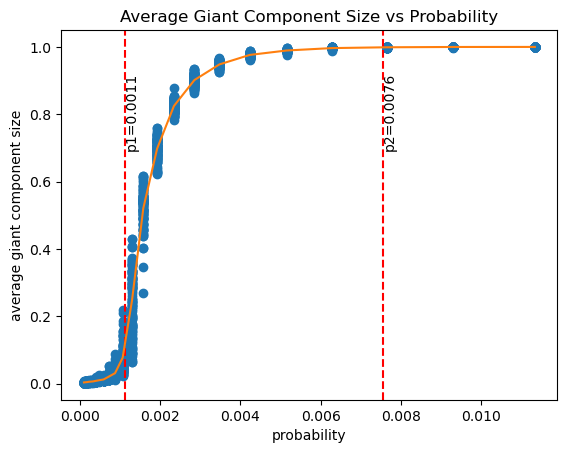

In [116]:
# Edit these values
epsilon = 0.5 # vary this value between 0 and 1
n_p_values = 25 # number of p values to test, log-spaced
n_iter = 100 # number of iterations for each p value to average over

# Don't edit these values
n = 900
p1 = 1/n
p2 = np.log(n)/n
p_max = (1+epsilon)*p2 # graph is almost surely connected if p > p_max
probabilities = np.logspace(-4, np.log10(p_max), n_p_values)
avg_gcc_vals = np.empty(n_p_values)

for i, p in enumerate(probabilities):
    gcc_values = np.empty(n_iter)
    for j in range(n_iter):
        graph = ig.Graph.Erdos_Renyi(n=n, p=p, directed=False, loops=False)
        gcc_values[j] = graph.connected_components().giant().vcount()/n
    avg_gcc_vals[i] = np.average(gcc_values)
    plt.scatter(n_iter*[p], gcc_values, color='#1f77b4')

plt.xlabel('probability')
plt.ylabel('average giant component size')
plt.title('Average Giant Component Size vs Probability')
plt.axvline(x=p1, color='r', linestyle='--')
plt.text(p1, 0.7, f'p1={round(p1, 4)}', rotation=90)
plt.axvline(x=p2, color='r', linestyle='--')
plt.text(p2, 0.7, f'p2={round(p2, 4)}', rotation=90)
plt.plot(probabilities, avg_gcc_vals, color="#ff7f0e")

## 1d

## 2a

1d. 

----------------


2a. the probability of attaching to a node is based on the number of edges it has. a hexagon with a point in the middle has a probability of 6/12 of connected to the center node p = degree(v)/(2nm) so probably degree(v)/|E|. Follows the 

All nodes in a preferential attachment model are connected

2b. Can find densly connected clusters called a community. Modularity is how easy you can find a community. If we can easily cluster a group it has a high modularity. Assortativity will be given in lecture, but it is something to do with a vertex. 

2c. 
2d. 
2e. generate model multiple times in order to get the degree distribution. can also do by hand
2f. 
2g. repeat previous part but with different values of n
2h. 

------------------

3a. also need to consider age of old nodes (ie order in which node is generated). $P(m) = P[i] ~ (ck^a_i+a)(dl^\beta_i+b)$
3b. 


Ask question about how early ot work in project ditching class and watching lectures


# Part 2